In [349]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt, seaborn as sns
import folium 
from sklearn.metrics.pairwise import (cosine_similarity, euclidean_distances, manhattan_distances) 
from IPython.display import display
from surprise import SVD, Dataset, NormalPredictor, Reader, accuracy, KNNBasic, KNNWithZScore, KNNWithMeans, KNNBaseline, evaluate
from surprise import get_dataset_dir
from surprise.model_selection import train_test_split
from collections import defaultdict


%matplotlib inline

# EDA 

### Read Business Dataset

In [2]:
business = pd.read_csv('../yelp_academic_dataset/yelp_business.csv')

In [3]:
business.head(2)

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
0,FYWN1wneV18bWNgQjJ2GNg,"""Dental by Design""",NaN,"""4855 E Warner Rd, Ste B9""",Ahwatukee,AZ,85044,33.330690,-111.978599,4.0,22,1,Dentists;General Dentistry;Health & Medical;Or...
1,He-G7vWjzVUysIKrfNbPUQ,"""Stephen Szabo Salon""",NaN,"""3101 Washington Rd""",McMurray,PA,15317,40.291685,-80.104900,3.0,11,1,Hair Stylists;Hair Salons;Men's Hair Salons;Bl...


### Dataset Includes ~175,000 Businesses

In [4]:
business.shape

(174567, 13)

### The Dataset includes 68 'State' values, I decided to look at only 'States' with more than 200 businesses

In [5]:
states = business['state'].value_counts()[business['state'].value_counts() > 200]

In [6]:
states = pd.DataFrame({'state':states.index, 'count':states.values})

In [7]:
states

,count,state
0,52214,AZ
1,33086,NV
2,30208,ON
3,12956,NC
4,12609,OH
5,10109,PA
6,8169,QC
7,4754,WI
8,3795,EDH
9,3118,BW


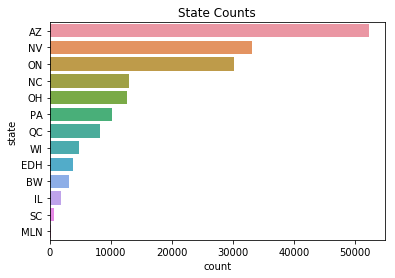

In [8]:
sns.barplot(x='count', y='state', data=states)
plt.title("State Counts");

### The Dataset includes ~1000 'City' values, I decided to look at only cities with more than 1000 businesses

In [9]:
cities = business['city'].value_counts()[business['city'].value_counts() > 1000]

In [10]:
cities = pd.DataFrame({'city':cities.index, 'count':cities.values})
cities

,city,count
0,Las Vegas,26775
1,Phoenix,17213
2,Toronto,17206
3,Charlotte,8553
4,Scottsdale,8228
5,Pittsburgh,6355
6,Mesa,5760
7,Montréal,5709
8,Henderson,4465
9,Tempe,4263


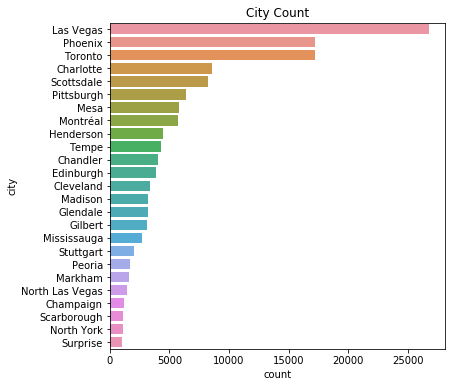

In [11]:
fig, ax = plt.subplots(figsize=(6,6))
sns.barplot(x='count', y='city', data=cities, ax=ax)
plt.title("City Count");

### Mask Business Dataset to Test Workability
#### First Use 'Las Vegas' (Largest Market) &  > 1000 reviews  (to improve matches between users)

In [12]:
business = business[(business['city'] == 'Las Vegas') & (business['review_count'] > 1000)]

In [13]:
business.shape

(186, 13)

In [14]:
business.head()

,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,categories
800,o7AiTlyWUrBSzdz6oMHj5w,"""Excalibur Hotel""",The Strip,"""Excalibur Hotel And Casino, 3850 Las Vegas Bl...",Las Vegas,NV,89109,36.098732,-115.174726,2.5,2504,1,Hotels;Event Planning & Services;Casinos;Resor...
801,PgJgpW4TKQ8IoALH2Yq-zA,"""Bayside Buffet at Mandalay Bay""",The Strip,"""3950 S Las Vegas Blvd""",Las Vegas,NV,89109,36.091219,-115.175804,3.0,1033,1,Arts & Entertainment;Restaurants;Buffets;Ameri...
2803,5iSmZO0SrKU6EoXK_1M8Kw,"""Monte Carlo Hotel And Casino""",The Strip,"""3770 Las Vegas Blvd S""",Las Vegas,NV,89109,36.104614,-115.176021,2.5,2507,1,Resorts;Hotels & Travel;Event Planning & Servi...
4416,OVTZNSkSfbl3gVB9XQIJfw,"""Cravings Buffet""",The Strip,"""3400 Las Vegas Blvd S""",Las Vegas,NV,89109,36.121237,-115.174105,3.0,1252,1,American (Traditional);Buffets;Restaurants;Ame...
4439,JDZ6_yycNQFTpUZzLIKHUg,"""El Dorado Cantina""",NaN,"""3025 Sammy Davis Jr Dr""",Las Vegas,NV,89109,36.134915,-115.175822,4.0,1694,1,Lounges;Mexican;Restaurants;Bars;Nightlife


### Truncate Business Columns

In [15]:
business_trunc = business[['business_id', 'name', 'city', 'state', 'review_count']]

In [16]:
business_trunc.head(5)

,business_id,name,city,state,review_count
800,o7AiTlyWUrBSzdz6oMHj5w,"""Excalibur Hotel""",Las Vegas,NV,2504
801,PgJgpW4TKQ8IoALH2Yq-zA,"""Bayside Buffet at Mandalay Bay""",Las Vegas,NV,1033
2803,5iSmZO0SrKU6EoXK_1M8Kw,"""Monte Carlo Hotel And Casino""",Las Vegas,NV,2507
4416,OVTZNSkSfbl3gVB9XQIJfw,"""Cravings Buffet""",Las Vegas,NV,1252
4439,JDZ6_yycNQFTpUZzLIKHUg,"""El Dorado Cantina""",Las Vegas,NV,1694


### Read User Dataset

In [17]:
user = pd.read_csv('../yelp_academic_dataset/yelp_user.csv')

In [18]:
user.head(2)

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,JJ-aSuM4pCFPdkfoZ34q0Q,Chris,10,2013-09-24,"0njfJmB-7n84DlIgUByCNw, rFn3Xe3RqHxRSxWOU19Gpg...",0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0
1,uUzsFQn_6cXDh6rPNGbIFA,Tiffy,1,2017-03-02,None,0,0,0,0,None,...,0,0,0,0,0,0,0,0,0,0


### Dataset Includes ~1.3 million users

In [19]:
user.shape

(1326100, 22)

### User Review Count is heavily skewed left, this makes logical since most users are known to write reviews infrequently

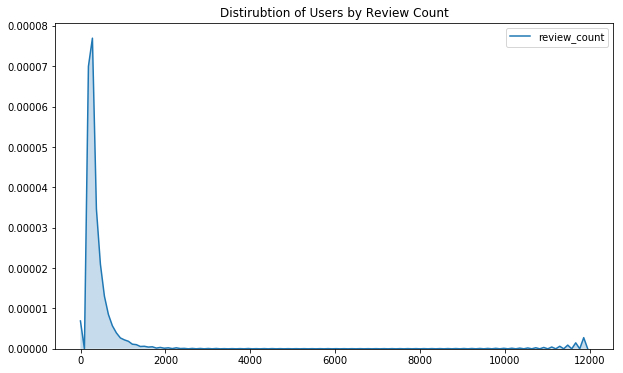

In [20]:
fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(user['review_count'], shade=True, ax=ax)
plt.title('Distirubtion of Users by Review Count');

### Individual Review scarcity is one of the inherent challenges for collaborative filtering with this dataset

In [21]:
pd.DataFrame(user['review_count'].describe())

,review_count
count,1.326100e+06
mean,2.311717e+01
std,7.909808e+01
min,0.000000e+00
25%,2.000000e+00
50%,5.000000e+00
75%,1.500000e+01
max,1.195400e+04


### Mask User Dataset to Test Workability
#### First Power Users w/ ' > 500' Reviews (to improve matches between businesses)

In [22]:
user = user[user['review_count'] > 500]

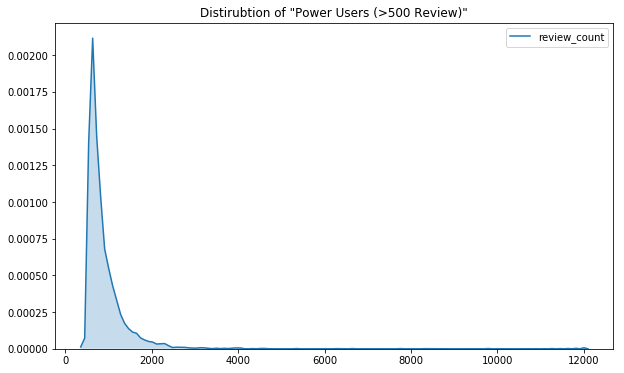

In [23]:
fig, ax = plt.subplots(figsize=(10,6))
sns.kdeplot(user['review_count'], shade=True, ax=ax)
plt.title('Distirubtion of "Power Users (>500 Review)"');

In [24]:
user['user_id'].value_counts().sum()

5903

### Truncate User Columns

In [25]:
user_trunc = user[['user_id', 'review_count']]

In [26]:
user_trunc.head()

,user_id,review_count
74,aw973Pm1nrTbRjP4zY9B9g,762
212,wm97KC6G0resSDXTmNIMKw,1262
730,oH9K7eCuNsYr6MmlM2ZjUg,902
756,bzMzZE3OCqHhZyXH5JRaWw,851
794,lmJy4OwP_TyHIg8a8Q0RsA,646


In [27]:
user_trunc.shape

(5903, 2)

### Read Review Dataset
#### This Dataset includes ~ 5.2 million reviews

In [28]:
reviews = pd.read_csv('../yelp_academic_dataset/yelp_review.csv')

In [29]:
reviews.head()

,review_id,user_id,business_id,stars,date,text,useful,funny,cool
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5,2016-05-28,Super simple place but amazing nonetheless. It...,0,0,0
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5,2016-05-28,Small unassuming place that changes their menu...,0,0,0
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5,2016-05-28,Lester's is located in a beautiful neighborhoo...,0,0,0
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4,2016-05-28,Love coming here. Yes the place always needs t...,0,0,0
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4,2016-05-28,Had their chocolate almond croissant and it wa...,0,0,0


In [30]:
reviews.shape

(5261668, 9)

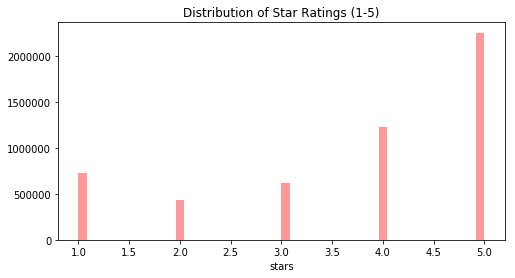

In [31]:
fig, ax = plt.subplots(figsize=(8,4))
sns.distplot(reviews['stars'], kde=False, color='red', ax=ax)
plt.title("Distribution of Star Ratings (1-5)");

### Review Rating Distribution is Skewed to the Right

In [32]:
pd.DataFrame(reviews['stars'].describe())

,stars
count,5.261668e+06
mean,3.727739e+00
std,1.433593e+00
min,1.000000e+00
25%,3.000000e+00
50%,4.000000e+00
75%,5.000000e+00
max,5.000000e+00


### Truncate Review Columns

In [33]:
reviews_trunc = reviews[['review_id', 'user_id', 'business_id','stars']]

In [34]:
reviews_trunc.head(10)

,review_id,user_id,business_id,stars
0,vkVSCC7xljjrAI4UGfnKEQ,bv2nCi5Qv5vroFiqKGopiw,AEx2SYEUJmTxVVB18LlCwA,5
1,n6QzIUObkYshz4dz2QRJTw,bv2nCi5Qv5vroFiqKGopiw,VR6GpWIda3SfvPC-lg9H3w,5
2,MV3CcKScW05u5LVfF6ok0g,bv2nCi5Qv5vroFiqKGopiw,CKC0-MOWMqoeWf6s-szl8g,5
3,IXvOzsEMYtiJI0CARmj77Q,bv2nCi5Qv5vroFiqKGopiw,ACFtxLv8pGrrxMm6EgjreA,4
4,L_9BTb55X0GDtThi6GlZ6w,bv2nCi5Qv5vroFiqKGopiw,s2I_Ni76bjJNK9yG60iD-Q,4
5,HRPm3vEZ_F-33TYVT7Pebw,_4iMDXbXZ1p1ONG297YEAQ,8QWPlVQ6D-OExqXoaD2Z1g,5
6,ymAUG8DZfQcFTBSOiaNN4w,u0LXt3Uea_GidxRW1xcsfg,9_CGhHMz8698M9-PkVf0CQ,4
7,8UIishPUD92hXtScSga_gw,u0LXt3Uea_GidxRW1xcsfg,gkCorLgPyQLsptTHalL61g,4
8,w41ZS9shepfO3uEyhXEWuQ,u0LXt3Uea_GidxRW1xcsfg,5r6-G9C4YLbC7Ziz57l3rQ,3
9,WF_QTN3p-thD74hqpp2j-Q,u0LXt3Uea_GidxRW1xcsfg,fDF_o2JPU8BR1Gya--jRIA,5


### Merge Datasets so that masks create a limited single DataFrame

In [244]:
df = reviews_trunc.merge(user_trunc, how='inner', on='user_id').merge(business_trunc, how='inner', on='business_id')

In [245]:
df.shape

(31908, 9)

### Drop Columns not needed for Model

In [246]:
df.drop(['review_id','review_count_x', 'name', 'city', 'state', 'review_count_y'], axis=1, inplace=True)

In [247]:
df.head()

,user_id,business_id,stars
0,tL2pS5UOmN6aAOi3Z-qFGg,eAc9Vd6loOgRQolMXQt6FA,4
1,3wB-JjsUjkvdNUDRnChsVg,eAc9Vd6loOgRQolMXQt6FA,4
2,3EAHMMsNnN4rrQVPPuzdnw,eAc9Vd6loOgRQolMXQt6FA,3
3,m8nDqQ7a3zQWfkNK1_vwnQ,eAc9Vd6loOgRQolMXQt6FA,4
4,-hxUwfo3cMnLTv-CAaP69A,eAc9Vd6loOgRQolMXQt6FA,4


In [248]:
df.shape

(31908, 3)

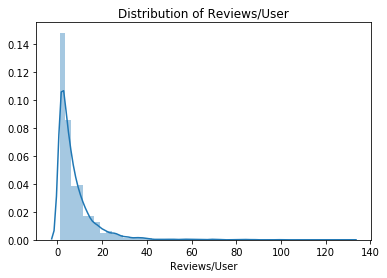

In [249]:
sns.distplot(df['user_id'].value_counts(), axlabel='Reviews/User')
plt.title("Distribution of Reviews/User");

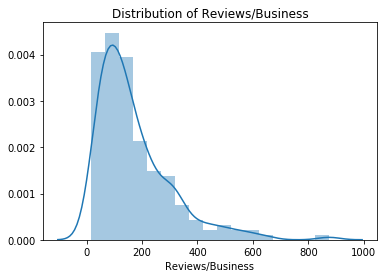

In [250]:
sns.distplot(df['business_id'].value_counts(), axlabel='Reviews/Business')
plt.title("Distribution of Reviews/Business");

#### Set Minimum # of User Reviews to Be Included in Sample

In [251]:
df = df.groupby('user_id').filter(lambda group: len(group) > 25)

#### Set Minimum # of Business Reviews to Be Included in Sample

In [252]:
df = df.groupby('business_id').filter(lambda group: len(group) > 15)

### DataFrame Descrptition  

In [253]:
print("\n")
print("Number of reviews included: %s " %df.shape[0])
print("")
print("Number of unique users included: %s" %df['user_id'].unique().size)
print("")
print("Number of unique businesses included: %s" %df['business_id'].unique().size)
print("\n")



Number of reviews included: 7082 

Number of unique users included: 181

Number of unique businesses included: 175




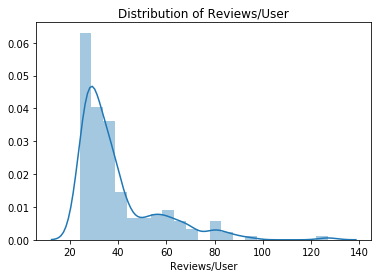

In [254]:
sns.distplot(df['user_id'].value_counts(), axlabel='Reviews/User')
plt.title("Distribution of Reviews/User");

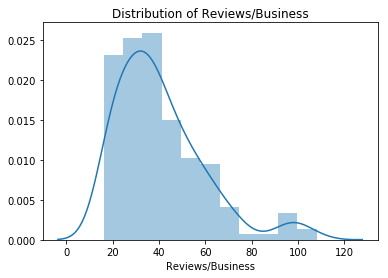

In [255]:
sns.distplot(df['business_id'].value_counts(), axlabel='Reviews/Business')
plt.title("Distribution of Reviews/Business");

### Adjusted limits help create a more normally distributed sample

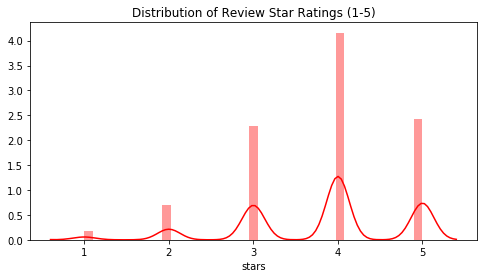

In [256]:
fig, ax = plt.subplots(figsize=(8,4))
sns.distplot(df['stars'], kde=True, color='red', ax=ax)
plt.title("Distribution of Review Star Ratings (1-5)");

In [257]:
pd.DataFrame(df['stars'].describe())

,stars
count,7082.000000
mean,3.814742
std,0.951659
min,1.000000
25%,3.000000
50%,4.000000
75%,4.000000
max,5.000000


## Create Model Using Surprise Package

In [347]:

# Create Reader w/ Scale to Import DataFrame into Surprise
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(df[['user_id', 'business_id', 'stars']], reader)

# Establish Baseline Scoring for Model 
# Algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal.
algo = NormalPredictor()

# Use Train_Test_Split on data
trainset, testset = train_test_split(data=data, test_size=.3, random_state=9)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
random_predictions = algo.test(testset)

# Then compute RMSE & MAE for Random 
print("Baseline Error using Random Ratings")
print(accuracy.rmse(random_predictions))
print(accuracy.mae(random_predictions))

Baseline Error using Random Ratings
RMSE: 1.2723
1.2722535052291544
MAE:  1.0199
1.0198840690190076


In [357]:
# Define Algorithm for Model

algo = sim_options = {'name': 'msd',
                }

algo = KNNWithMeans(sim_options=sim_options)

# Use Train_Test_Split on data
trainset, testset = train_test_split(data=data, test_size=.3, random_state=9)

# Train the algorithm on the trainset, and predict ratings for the testset
algo.fit(trainset)
predictions = algo.test(testset)

# Then compute RMSE & MAE
print("Error Using MSD and KNNWithMeans Model")
print(accuracy.rmse(predictions))
print(accuracy.mae(predictions))

Computing the msd similarity matrix...
Done computing similarity matrix.
Error Using MSD and KNNWithMeans Model
RMSE: 0.8648
0.8647681232455616
MAE:  0.6725
0.6725002270938957


#### Example Estimated Rating vs True Rating

In [261]:
print(predictions[1])
print(predictions[2])
print(predictions[3])

user: 41HLwXnR0Lm3NUp01cIOQg item: 4JNXUYY8wbaaDmk3BPzlWw r_ui = 3.00   est = 3.75   {'actual_k': 40, 'was_impossible': False}
user: gZHCbDOkHdHIk2d02FN3kw item: 77h11eWv6HKJAgojLx8G4w r_ui = 3.00   est = 3.79   {'actual_k': 14, 'was_impossible': False}
user: rt3PC7WCgCKsoufmQJELfw item: 2weQS-RnoOBhb1KsHKyoSQ r_ui = 4.00   est = 3.68   {'actual_k': 40, 'was_impossible': False}


## Create Function to Rank Top Predictions(Recommended Businesses) / User

In [344]:
def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n


# Create a training set using all ratings
trainset = data.build_full_trainset()

# Train model using MSD measurement and KNN
algo = sim_options = {'name': 'msd'
                }
    
algo = KNNWithMeans(sim_options=sim_options)
               
algo.fit(trainset)

# Than predict ratings for all pairs (u, i) that are NOT in the training set.
testset = trainset.build_anti_testset()
predictions = algo.test(testset)

#predictions

top_n = get_top_n(predictions, n=3)

#create dataframe with top 3 recommendations by user with estimated scores and business_ids

top_3df = pd.DataFrame(list(top_n.items()), columns=['user_id', 'recos'])
top_3df[['Reco_1','Reco_2', 'Reco_3']] = pd.DataFrame(top_3df.recos.values.tolist(), index= top_3df.index)
top_3df.drop(['recos'], axis=1, inplace=True)
top_3df[['1st Recommendation', '1st Est Rating']] = top_3df['Reco_1'].apply(pd.Series)
top_3df[['2nd Recommendation', '2nd Est Rating']] = top_3df['Reco_2'].apply(pd.Series)
top_3df[['3rd Recommendation', '3rd Est Rating']] = top_3df['Reco_3'].apply(pd.Series)
top_3df.drop(['Reco_1', 'Reco_2', 'Reco_3'], axis=1, inplace=True)
top_3df.head()

Computing the msd similarity matrix...
Done computing similarity matrix.


,user_id,1st Recommendation,1st Est Rating,2nd Recommendation,2nd Est Rating,3rd Recommendation,3rd Est Rating
0,3wB-JjsUjkvdNUDRnChsVg,NCFwm2-TDb-oBQ2medmYDg,4.548096,8mIrX_LrOnAqWsB5JrOojQ,4.452554,ty5KQYqYRxwXDG_e4pz-4w,4.342305
1,YMgZqBUAddmFErxLtCfK_w,IhNASEZ3XnBHmuuVnWdIwA,4.505934,BH9z7IJ4zydAqgwsbqoVZQ,4.483402,sqRX-XLlhx4rs2c1TpBf8A,4.354010
2,wa40Yx8wrZfiRqTgZsdd0g,NCFwm2-TDb-oBQ2medmYDg,4.201278,IhNASEZ3XnBHmuuVnWdIwA,4.099090,8mIrX_LrOnAqWsB5JrOojQ,4.082000
3,CiJat5Up2jAO3B0qTbiN5Q,8mIrX_LrOnAqWsB5JrOojQ,4.880460,sqRX-XLlhx4rs2c1TpBf8A,4.816272,IhNASEZ3XnBHmuuVnWdIwA,4.780135
4,wkrFqNxwTEEkG3mJV88Izw,MpmFFw0GE_2iRFPdsRpJbA,4.644147,BH9z7IJ4zydAqgwsbqoVZQ,4.642222,IhNASEZ3XnBHmuuVnWdIwA,4.635950


### Create List of Available User_Ids w/ Names and Meta Data

In [345]:
top_3df = top_3df.merge(user, how='inner', on='user_id')
top_3df.drop(['yelping_since', 'friends', 'useful', 'funny', 'cool',
       'fans', 'elite', 'compliment_hot', 'compliment_more',
       'compliment_profile', 'compliment_cute', 'compliment_list',
       'compliment_note', 'compliment_plain', 'compliment_cool',
       'compliment_funny', 'compliment_writer', 'compliment_photos'], axis=1)
top_3df = top_3df[['user_id', 'name', '1st Recommendation','1st Est Rating', '2nd Recommendation', '2nd Est Rating', '3rd Recommendation', '3rd Est Rating', 'review_count', 'average_stars']]
top_3df.head()

,user_id,name,1st Recommendation,1st Est Rating,2nd Recommendation,2nd Est Rating,3rd Recommendation,3rd Est Rating,review_count,average_stars
0,3wB-JjsUjkvdNUDRnChsVg,Brandon,NCFwm2-TDb-oBQ2medmYDg,4.548096,8mIrX_LrOnAqWsB5JrOojQ,4.452554,ty5KQYqYRxwXDG_e4pz-4w,4.342305,1160,3.40
1,YMgZqBUAddmFErxLtCfK_w,Samantha,IhNASEZ3XnBHmuuVnWdIwA,4.505934,BH9z7IJ4zydAqgwsbqoVZQ,4.483402,sqRX-XLlhx4rs2c1TpBf8A,4.354010,1709,3.61
2,wa40Yx8wrZfiRqTgZsdd0g,Melanie,NCFwm2-TDb-oBQ2medmYDg,4.201278,IhNASEZ3XnBHmuuVnWdIwA,4.099090,8mIrX_LrOnAqWsB5JrOojQ,4.082000,661,3.61
3,CiJat5Up2jAO3B0qTbiN5Q,Denise,8mIrX_LrOnAqWsB5JrOojQ,4.880460,sqRX-XLlhx4rs2c1TpBf8A,4.816272,IhNASEZ3XnBHmuuVnWdIwA,4.780135,1021,4.11
4,wkrFqNxwTEEkG3mJV88Izw,Olivia,MpmFFw0GE_2iRFPdsRpJbA,4.644147,BH9z7IJ4zydAqgwsbqoVZQ,4.642222,IhNASEZ3XnBHmuuVnWdIwA,4.635950,1065,3.80


In [264]:
user_list = df['user_id'].unique().tolist()
user_list[:10]

['3wB-JjsUjkvdNUDRnChsVg',
 'YMgZqBUAddmFErxLtCfK_w',
 'wa40Yx8wrZfiRqTgZsdd0g',
 'CiJat5Up2jAO3B0qTbiN5Q',
 'wkrFqNxwTEEkG3mJV88Izw',
 'hZfzVrhsCQ9JDAb2jYoJNQ',
 'Um5bfs5DH6eizgjH3xZsvg',
 'qPVtjjp8sNQ32p9860SR9Q',
 'EiwxlbR8fb68lMgEXhcWKA',
 'Thc2zV-K-KLcvJn3fMPdqQ']

## Function to show top 3 recommendations for User w/ business metadata

In [309]:
def new_user_recommendations(user):
    
    # Createe User_Recommendations Dataframe merged with Business Metadata
    
    user_recommendations = top_3df.query("user_id == '"+user+"'")
    user_recommendations = user_recommendations.T.reset_index()
    user_recommendations.columns = ['Info', 'business_id']
    user_recommendations = user_recommendations.merge(business, how='inner', on='business_id')
    user_recommendations.drop(['is_open', 'postal_code', 'address'], axis=1, inplace=True)
    
    return user_recommendations

In [346]:
new_user_recommendations('wa40Yx8wrZfiRqTgZsdd0g')

,Info,business_id,name,neighborhood,city,state,latitude,longitude,stars,review_count,categories
0,1st Recommendation,NCFwm2-TDb-oBQ2medmYDg,"""Fountains of Bellagio""",The Strip,Las Vegas,NV,36.112986,-115.174078,4.5,1109,Landmarks & Historical Buildings;Public Servic...
1,2nd Recommendation,IhNASEZ3XnBHmuuVnWdIwA,"""Brew Tea Bar""",Southwest,Las Vegas,NV,36.054195,-115.242443,5.0,1165,Cafes;Tea Rooms;Food;Bubble Tea;Restaurants;De...
2,3rd Recommendation,8mIrX_LrOnAqWsB5JrOojQ,"""Pinball Hall Of Fame""",University,Las Vegas,NV,36.101449,-115.130511,4.5,1095,Museums;Active Life;Amusement Parks;Performing...


## Function to map top 3 recommendations to interactive map

In [328]:
def new_user_recommendations_map(user):
    # Create user_recommendations df from new_recommendation function
    user_recommendations = new_user_recommendations(user)

    # Create interactive map w/ top 3 recommendations dropped as markers
    location=[user_recommendations.iloc[0]['latitude'], user_recommendations.iloc[0]['longitude']]
    m = folium.Map(location, width='80%', height='80%', max_zoom=15, min_zoom=11, zoom_start=11, control_scale=True)
    for i in range(0,len(user_recommendations)):
        folium.Marker([user_recommendations.iloc[i]['latitude'], user_recommendations.iloc[i]['longitude']],\
        popup=user_recommendations.iloc[i]['name']).add_to(m)
    return m

In [329]:
new_user_recommendations_map('wa40Yx8wrZfiRqTgZsdd0g')

In [ ]:
![title](user_recommendations.png)

### Find Top 3 Nearest Neighbors to Selected User in the MSD similarity Matrix

In [323]:
user_id = algo.trainset.to_inner_uid('wa40Yx8wrZfiRqTgZsdd0g')
neighbors = algo.get_neighbors(user_id, k=3)
user_neighbors = list(algo.trainset.to_raw_uid(inner_id) for inner_id in neighbors)
user_neighbors = pd.Series(user_neighbors)
user_neighbors = pd.DataFrame(user_neighbors, columns=['user_id'])
user_neighbors.merge(user, how='inner', on='user_id')

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,7Oe6ikklTjVBbEFw9emLcA,Terri,761,2010-07-30,"ObQl16Vuc4sHPGKtzSGNUw, 4zGUfXRDgbLktXsYf0sHjQ...",8243,3009,7640,130,"2013, 2016, 2017, 2015, 2012, 2014",...,25,19,22,5,298,1056,1039,1039,247,417
1,CNaaizAUc2c4WIb1M3BBPw,Rockne,639,2012-03-09,"kDGhswMrYIOaFJAViW_nCA, gtwM4ijo65AN4DvXdgCu_w...",8,6,6,76,"2014, 2017, 2015, 2013, 2012, 2016",...,10,4,1,0,37,51,108,108,85,23
2,hZfzVrhsCQ9JDAb2jYoJNQ,Ashley,719,2011-01-15,"T2oa39v5AgWQ-SYt3RGghg, f5K81kHTFniTSJAVewcuDg...",257,103,80,52,"2016, 2014, 2013, 2015, 2011, 2012, 2017",...,9,4,3,5,42,69,108,108,64,9


### Function to show user's previously rated businesses included in the model (for comparison)

In [330]:
def new_user_previously_rated(user):
    
    # Show users previously rated businesses from Dataframe merged with Business Metadata
    
    previously_rated = df[df['user_id'] == user]
    previously_rated = previously_rated.merge(business, how='inner', on='business_id')
    previously_rated = previously_rated.rename({'stars_x': 'user rating'})
    previously_rated.rename(columns = {'stars_x':'user rating', 'stars_y': 'business rating'}, inplace = True)
    previously_rated.drop(['is_open', 'address', 'postal_code'], axis=1, inplace=True)
    
    return previously_rated

In [331]:
# Sample User

new_user_previously_rated('wa40Yx8wrZfiRqTgZsdd0g')

,user_id,business_id,user rating,name,neighborhood,city,state,latitude,longitude,business rating,review_count,categories
0,wa40Yx8wrZfiRqTgZsdd0g,eAc9Vd6loOgRQolMXQt6FA,5,"""Mandalay Bay Resort & Casino""",The Strip,Las Vegas,NV,36.091895,-115.175256,3.5,2687,Casinos;Hotels;Hotels & Travel;Resorts;Arts & ...
1,wa40Yx8wrZfiRqTgZsdd0g,ZibmYdOPKLlqDM9oR6xzOA,5,"""Bachi Burger""",Westside,Las Vegas,NV,36.146910,-115.300777,4.0,1068,Asian Fusion;Burgers;American (New);Bars;Wine ...
2,wa40Yx8wrZfiRqTgZsdd0g,El4FC8jcawUVgw_0EIcbaQ,2,"""MGM Grand Hotel""",The Strip,Las Vegas,NV,36.102251,-115.169968,3.0,3444,Restaurants;Arts & Entertainment;Hotels;Event ...
3,wa40Yx8wrZfiRqTgZsdd0g,t-o_Sraneime4DDhWrQRBA,3,"""Wynn Las Vegas""",The Strip,Las Vegas,NV,36.127684,-115.165905,4.0,2441,Casinos;Event Planning & Services;Nightlife;Re...
4,wa40Yx8wrZfiRqTgZsdd0g,Az_60nNuh1FH8Ds8oasZjw,3,"""Encore""",The Strip,Las Vegas,NV,36.127684,-115.167446,4.0,1726,Resorts;Home & Garden;Casinos;Arts & Entertain...
5,wa40Yx8wrZfiRqTgZsdd0g,9SU7ZZhaFUJJ6m2k5HKHeg,1,"""SLS Las Vegas Hotel & Casino""",The Strip,Las Vegas,NV,36.142275,-115.156245,3.0,1754,Lounges;Arts & Entertainment;Bars;Nightlife;Ho...
6,wa40Yx8wrZfiRqTgZsdd0g,qjnJFZtsY_nfRzoL3J_UWQ,3,"""New York New York Hotel & Casino""",The Strip,Las Vegas,NV,36.101118,-115.173586,3.5,1831,Hotels;Resorts;Casinos;Event Planning & Servic...
7,wa40Yx8wrZfiRqTgZsdd0g,eEnNw3_hBvxcFHyr23kAuA,2,"""Hard Rock Hotel & Casino""",Eastside,Las Vegas,NV,36.109230,-115.154036,3.0,2066,Bars;Arts & Entertainment;Nightlife;Hotels & T...
8,wa40Yx8wrZfiRqTgZsdd0g,VsewHMsfj1Mgsl2i_hio7w,4,"""LAVO Italian Restaurant & Lounge""",The Strip,Las Vegas,NV,36.124434,-115.169069,3.5,1474,Restaurants;Dance Clubs;Lounges;Nightlife;Ital...
9,wa40Yx8wrZfiRqTgZsdd0g,5iSmZO0SrKU6EoXK_1M8Kw,3,"""Monte Carlo Hotel And Casino""",The Strip,Las Vegas,NV,36.104614,-115.176021,2.5,2507,Resorts;Hotels & Travel;Event Planning & Servi...


In [332]:
# Neighbor 1 - Terri

new_user_previously_rated('7Oe6ikklTjVBbEFw9emLcA')

,user_id,business_id,user rating,name,neighborhood,city,state,latitude,longitude,business rating,review_count,categories
0,7Oe6ikklTjVBbEFw9emLcA,ZibmYdOPKLlqDM9oR6xzOA,5,"""Bachi Burger""",Westside,Las Vegas,NV,36.146910,-115.300777,4.0,1068,Asian Fusion;Burgers;American (New);Bars;Wine ...
1,7Oe6ikklTjVBbEFw9emLcA,XXW_OFaYQkkGOGniujZFHg,5,"""The Peppermill Restaurant & Fireside Lounge""",The Strip,Las Vegas,NV,36.133667,-115.163095,4.0,2703,Bars;American (Traditional);Lounges;Nightlife;...
2,7Oe6ikklTjVBbEFw9emLcA,SVGApDPNdpFlEjwRQThCxA,4,"""Juan's Flaming Fajitas & Cantina""",Spring Valley,Las Vegas,NV,36.100509,-115.302689,4.5,1210,Restaurants;Bars;Nightlife;Mexican
3,7Oe6ikklTjVBbEFw9emLcA,d_L-rfS1vT3JMzgCUGtiow,4,"""Border Grill""",The Strip,Las Vegas,NV,36.090067,-115.176973,4.0,1432,Restaurants;Breakfast & Brunch;Mexican;Tapas/S...
4,7Oe6ikklTjVBbEFw9emLcA,5LNZ67Yw9RD6nf4_UhXOjw,5,"""The Cosmopolitan of Las Vegas""",The Strip,Las Vegas,NV,36.109746,-115.173888,4.0,3772,Hotels;Event Planning & Services;Casinos;Hotel...
5,7Oe6ikklTjVBbEFw9emLcA,GI-CAiZ_Gg3h21PwrANB4Q,4,"""Mastro's Ocean Club""",The Strip,Las Vegas,NV,36.107924,-115.174055,4.5,1246,American (Traditional);Seafood;Restaurants;Ste...
6,7Oe6ikklTjVBbEFw9emLcA,G-5kEa6E6PD5fkBRuA7k9Q,5,"""Giada""",The Strip,Las Vegas,NV,36.115059,-115.172109,3.5,2349,Italian;Restaurants
7,7Oe6ikklTjVBbEFw9emLcA,FaHADZARwnY4yvlvpnsfGA,4,"""McCarran International Airport""",Southeast,Las Vegas,NV,36.085016,-115.151009,3.5,3284,Hotels & Travel;Airports
8,7Oe6ikklTjVBbEFw9emLcA,rcaPajgKOJC2vo_l3xa42A,5,"""Bouchon at the Venezia Tower""",The Strip,Las Vegas,NV,36.120955,-115.169853,4.0,3570,Breakfast & Brunch;Venues & Event Spaces;Event...
9,7Oe6ikklTjVBbEFw9emLcA,j5nPiTwWEFr-VsePew7Sjg,4,"""Ichiza""",Chinatown,Las Vegas,NV,36.125908,-115.197904,4.0,1378,Japanese;Restaurants


In [333]:
# Neighbor 2 - Rockne

new_user_previously_rated('CNaaizAUc2c4WIb1M3BBPw')

,user_id,business_id,user rating,name,neighborhood,city,state,latitude,longitude,business rating,review_count,categories
0,CNaaizAUc2c4WIb1M3BBPw,XXW_OFaYQkkGOGniujZFHg,3,"""The Peppermill Restaurant & Fireside Lounge""",The Strip,Las Vegas,NV,36.133667,-115.163095,4.0,2703,Bars;American (Traditional);Lounges;Nightlife;...
1,CNaaizAUc2c4WIb1M3BBPw,EAwh1OmG6t6p3nRaZOW_AA,4,"""Ellis Island Hotel, Casino & Brewery""",Eastside,Las Vegas,NV,36.113025,-115.163485,4.0,1946,Bars;Barbeque;Karaoke;Food;Breweries;Restauran...
2,CNaaizAUc2c4WIb1M3BBPw,d_L-rfS1vT3JMzgCUGtiow,4,"""Border Grill""",The Strip,Las Vegas,NV,36.090067,-115.176973,4.0,1432,Restaurants;Breakfast & Brunch;Mexican;Tapas/S...
3,CNaaizAUc2c4WIb1M3BBPw,Pob7ibbNT29--69nxXEP2g,4,"""The Chandelier""",The Strip,Las Vegas,NV,36.109746,-115.173903,4.0,1050,Bars;Lounges;Nightlife
4,CNaaizAUc2c4WIb1M3BBPw,iCQpiavjjPzJ5_3gPD5Ebg,5,"""Secret Pizza""",The Strip,Las Vegas,NV,36.112372,-115.173064,4.0,3741,Pizza;Restaurants
5,CNaaizAUc2c4WIb1M3BBPw,5LNZ67Yw9RD6nf4_UhXOjw,4,"""The Cosmopolitan of Las Vegas""",The Strip,Las Vegas,NV,36.109746,-115.173888,4.0,3772,Hotels;Event Planning & Services;Casinos;Hotel...
6,CNaaizAUc2c4WIb1M3BBPw,SMPbvZLSMMb7KU76YNYMGg,4,"""ARIA Resort & Casino""",The Strip,Las Vegas,NV,36.107621,-115.177040,3.5,3794,Event Planning & Services;Arts & Entertainment...
7,CNaaizAUc2c4WIb1M3BBPw,Cni2l-VKG_pdospJ6xliXQ,4,"""Burger Bar""",The Strip,Las Vegas,NV,36.094460,-115.176113,4.0,2440,Bars;American (Traditional);Burgers;American (...
8,CNaaizAUc2c4WIb1M3BBPw,2iTsRqUsPGRH1li1WVRvKQ,5,"""Carson Kitchen""",Downtown,Las Vegas,NV,36.167878,-115.140640,4.5,1586,Salad;Comfort Food;Gastropubs;Nightlife;Cockta...
9,CNaaizAUc2c4WIb1M3BBPw,3xmfT7l3xNH5LK1dLzfvGw,4,"""Fremont Street Experience""",Downtown,Las Vegas,NV,36.169182,-115.141881,3.5,1311,Local Flavor;Casinos;Bars;Nightlife;Arts & Ent...


In [334]:
# Neighbor 3 - Ashley

new_user_previously_rated('hZfzVrhsCQ9JDAb2jYoJNQ')

,user_id,business_id,user rating,name,neighborhood,city,state,latitude,longitude,business rating,review_count,categories
0,hZfzVrhsCQ9JDAb2jYoJNQ,eAc9Vd6loOgRQolMXQt6FA,4,"""Mandalay Bay Resort & Casino""",The Strip,Las Vegas,NV,36.091895,-115.175256,3.5,2687,Casinos;Hotels;Hotels & Travel;Resorts;Arts & ...
1,hZfzVrhsCQ9JDAb2jYoJNQ,ZibmYdOPKLlqDM9oR6xzOA,5,"""Bachi Burger""",Westside,Las Vegas,NV,36.146910,-115.300777,4.0,1068,Asian Fusion;Burgers;American (New);Bars;Wine ...
2,hZfzVrhsCQ9JDAb2jYoJNQ,EAwh1OmG6t6p3nRaZOW_AA,3,"""Ellis Island Hotel, Casino & Brewery""",Eastside,Las Vegas,NV,36.113025,-115.163485,4.0,1946,Bars;Barbeque;Karaoke;Food;Breweries;Restauran...
3,hZfzVrhsCQ9JDAb2jYoJNQ,0NmTwqYEQiKErDv4a55obg,1,"""Scarpetta""",The Strip,Las Vegas,NV,36.110241,-115.174288,4.0,1171,Restaurants;Italian
4,hZfzVrhsCQ9JDAb2jYoJNQ,d_L-rfS1vT3JMzgCUGtiow,3,"""Border Grill""",The Strip,Las Vegas,NV,36.090067,-115.176973,4.0,1432,Restaurants;Breakfast & Brunch;Mexican;Tapas/S...
5,hZfzVrhsCQ9JDAb2jYoJNQ,QJatAcxYgK1Zp9BRZMAx7g,2,"""Shake Shack""",The Strip,Las Vegas,NV,36.103061,-115.173450,4.0,2549,Burgers;American (New);Restaurants
6,hZfzVrhsCQ9JDAb2jYoJNQ,Pob7ibbNT29--69nxXEP2g,5,"""The Chandelier""",The Strip,Las Vegas,NV,36.109746,-115.173903,4.0,1050,Bars;Lounges;Nightlife
7,hZfzVrhsCQ9JDAb2jYoJNQ,LFs5jyYdXlzi0SpAYi1eSA,2,"""Maggiano's Little Italy""",The Strip,Las Vegas,NV,36.127783,-115.168968,4.0,1250,Nightlife;Bars;Italian;Restaurants
8,hZfzVrhsCQ9JDAb2jYoJNQ,LwQB9H3jZ9wTk24Lr-AnZQ,4,"""Spago by Wolfgang Puck""",The Strip,Las Vegas,NV,36.118831,-115.175638,4.0,1056,Pizza;American (Traditional);American (New);Re...
9,hZfzVrhsCQ9JDAb2jYoJNQ,5iSmZO0SrKU6EoXK_1M8Kw,3,"""Monte Carlo Hotel And Casino""",The Strip,Las Vegas,NV,36.104614,-115.176021,2.5,2507,Resorts;Hotels & Travel;Event Planning & Servi...


In [170]:
def new_user_recommendations_map(user):
    # Create user_recommendations df from new_recommendation function
    user_recommendations = new_user_recommendations(user)

    # Create interactive map w/ top 5 recommendations dropped as points
    location=[user_recommendations.iloc[0]['latitude'], user_recommendations.iloc[0]['longitude']]
    m = folium.Map(location, width='80%', height='80%', max_zoom=15, min_zoom=11, zoom_start=11, control_scale=True)
    for i in range(0,len(user_recommendations)):
        folium.Marker([user_recommendations.iloc[i]['latitude'], user_recommendations.iloc[i]['longitude']],\
        popup=user_recommendations.iloc[i]['name']).add_to(m)
    return m

![title](user_recommendations.png)

In [172]:
business_list = df['business_id'].unique().tolist()
business_list[:10]

['eAc9Vd6loOgRQolMXQt6FA',
 'ZibmYdOPKLlqDM9oR6xzOA',
 'XXW_OFaYQkkGOGniujZFHg',
 'SVGApDPNdpFlEjwRQThCxA',
 'El4FC8jcawUVgw_0EIcbaQ',
 'EAwh1OmG6t6p3nRaZOW_AA',
 'g8OnV26ywJlZpezdBnOWUQ',
 'ByFMv3p5X1aNeZhU61rDcA',
 'oVrvzUJczq0e2JzVxSTyag',
 '0AQnRQw34IQW9-1gJkYnMA']

### Create Function to Find New Customers for Given Business where Business showed up in those users top 3 recommendations

In [173]:
def new_business_customers(business):
    business_customers = top_3df.loc[(top_3df['1st Recommendation'] == business) | \
        (top_3df['2nd Recommendation'] == business) | \
        (top_3df['3rd Recommendation'] == business)]
    business_customers = business_customers[['user_id', 'name']]
    business_customers = business_customers.merge(user, how='inner', on='user_id')
    business_customers = business_customers.drop(['name_y'], axis=1)
    business_customers = business_customers.rename(columns={'name_x': 'name'})
    return business_customers

In [307]:
# Use Nearest Neighbor (Terri) to Sample User and find their top 3 recommendations

new_user_recommendations('7Oe6ikklTjVBbEFw9emLcA')

,Info,business_id,name,neighborhood,address,city,state,postal_code,latitude,longitude,stars,review_count,categories
0,1st Recommendation,A-uZAD4zP3rRxb44WUGV5w,"""Soho Japanese Restaurant""",Southwest,"""7377 S Jones Blvd, Ste 116""",Las Vegas,NV,89139,36.055244,-115.225870,4.5,1289,Restaurants;Sushi Bars;Asian Fusion;Japanese
1,2nd Recommendation,sqRX-XLlhx4rs2c1TpBf8A,"""Raku""",Chinatown,"""5030 Spring Mountain Rd, Ste 2""",Las Vegas,NV,89146,36.127033,-115.210028,4.5,1307,Seafood;Desserts;Japanese;Restaurants;Food
2,3rd Recommendation,BH9z7IJ4zydAqgwsbqoVZQ,"""Cirque du Soleil - O""",The Strip,"""Bellagio Las Vegas, 3600 S Las Vegas Blvd""",Las Vegas,NV,89109,36.114062,-115.177260,4.5,1420,Arts & Entertainment;Performing Arts


In [306]:
# Select Business_Id for "Soho Japanese Restaurant"
# Result shows 12 Users that this business should absolutely want to advertise directly to,
# including our selected user Terri

new_business_customers('A-uZAD4zP3rRxb44WUGV5w')

,user_id,name,review_count,yelping_since,friends,useful,funny,cool,fans,elite,...,compliment_more,compliment_profile,compliment_cute,compliment_list,compliment_note,compliment_plain,compliment_cool,compliment_funny,compliment_writer,compliment_photos
0,YMgZqBUAddmFErxLtCfK_w,Samantha,1709,2009-03-16,"UoSKsPjk11-Q7dFdW31pUQ, xAWA2aheTP6YwcFWgmeLaQ...",1170,144,253,131,"2013, 2010, 2015, 2017, 2014, 2012, 2011, 2016",...,11,9,2,13,58,110,156,156,93,37
1,hZfzVrhsCQ9JDAb2jYoJNQ,Ashley,719,2011-01-15,"T2oa39v5AgWQ-SYt3RGghg, f5K81kHTFniTSJAVewcuDg...",257,103,80,52,"2016, 2014, 2013, 2015, 2011, 2012, 2017",...,9,4,3,5,42,69,108,108,64,9
2,Um5bfs5DH6eizgjH3xZsvg,Dianna,2275,2011-12-05,"wLtPAwleONbhQgwgKhc-XQ, PzD7yjsAzBgjVmdiNu0hmw...",258,48,71,124,"2015, 2017, 2013, 2016, 2014",...,13,5,5,0,104,88,153,153,160,94
3,PKEzKWv_FktMm2mGPjwd0Q,Norm,2239,2008-12-12,"uIjj7EIVBU4kGNgmKPO02A, pbBn0hXz8diwlZ3RIy4UUg...",1468,896,1555,224,"2010, 2014, 2013, 2011, 2012, 2015, 2016, 2017",...,55,20,15,9,346,1960,1522,1522,593,547
4,y3FcL4bLy0eLlkb0SDPnBQ,Mel,1459,2011-12-11,"HPGZtz91yLiwS9-R1DHbeg, C2C0GPKvzWWnP57Os9eQ0w...",3260,3138,3185,137,"2017, 2014, 2013, 2016, 2012, 2015",...,58,31,7,19,358,1135,1231,1231,488,343
5,CQUDh80m48xnzUkx-X5NAw,David,3734,2008-12-29,"7UxOWZ_4rDk3zAWhkd0AfQ, kZXWjmCV2O_ylz2xQg2kRw...",3026,1898,2767,493,"2014, 2010, 2009, 2012, 2013, 2011",...,149,136,66,286,1024,1517,1540,1540,481,173
6,7Oe6ikklTjVBbEFw9emLcA,Terri,761,2010-07-30,"ObQl16Vuc4sHPGKtzSGNUw, 4zGUfXRDgbLktXsYf0sHjQ...",8243,3009,7640,130,"2013, 2016, 2017, 2015, 2012, 2014",...,25,19,22,5,298,1056,1039,1039,247,417
7,xhhE0txKwQtRzgQVVdKkvg,Bethany,945,2013-03-27,"WDpvs6U_TCx4799oxXcnag, c0kGm05-YW94DDE-LsD51g...",793,472,677,115,"2015, 2017, 2014, 2016, 2013",...,16,20,6,0,134,310,528,528,188,163
8,bQCHF5rn5lMI9c5kEwCaNA,Vincent,2985,2012-03-18,"bOzsdIkTveA6glHOOMPpkg, x8vCnMf1yPzv5TccQJP8kw...",5200,4992,5111,95,"2014, 2013, 2017, 2012, 2015, 2016",...,6,2,0,0,27,132,138,138,62,35
9,3nIuSCZk5f_2WWYMLN7h3w,Lauren,966,2015-06-07,"jJDEwznWHQIaT4Z0lIFl5A, 0tvCcnfJnSs55iB6mqPk3w...",381,69,255,66,"2015, 2017, 2016",...,4,0,2,1,26,50,70,70,49,51


In [305]:
df[df['business_id'] == 'A-uZAD4zP3rRxb44WUGV5w'].describe()

,stars
count,25.000000
mean,4.440000
std,0.711805
min,3.000000
25%,4.000000
50%,5.000000
75%,5.000000
max,5.000000


---

## Function to show that model gives stable results for other markets

In [358]:
def model_stats(business_city, business_review_count, user_review_count):
    
    '''Return the dataframe counts (users, businesses, and ratings) of a specific city.
       Return Star Rating distribution and summary statistics
       Return baseline RMSE & MAE score and Model RMSE & MAE Score.
       Return Runtime
       

    Args:
        business_city from the business dataframe (String)
        business_review_count from business dataframe (Integer)
        user_review_count from business dataframe (Integer)
        
    '''
    
    # Read in datasets
    df_business = pd.read_csv('../yelp_academic_dataset/yelp_business.csv')
    df_user = pd.read_csv('../yelp_academic_dataset/yelp_user.csv')
    df_reviews = pd.read_csv('../yelp_academic_dataset/yelp_review.csv')

    
    # Mask business dataset by 'City' & 'Review Count' 
    df_business = df_business[(df_business['city'] == business_city) & (df_business['review_count'] > business_review_count)]
    
    # Mask user dataset by user review count
    df_user = df_user[df_user['review_count'] > user_review_count]
    
    # Truncate datasets
    df_business_trunc = df_business[['business_id', 'name', 'city', 'state', 'review_count']]
    df_user_trunc = df_user[['user_id', 'review_count']] 
    df_reviews_trunc = df_reviews[['review_id', 'user_id', 'business_id','stars']]
    
    # Merge into single dataset & Drop extra columnns
    df_merge = df_reviews_trunc.merge(df_user_trunc, how='inner', on='user_id').merge(df_business_trunc, how='inner', on='business_id')
    df_merge.drop(['review_id','review_count_x', 'name', 'city', 'state', 'review_count_y'], axis=1, inplace=True)
    
    # Limit new dataframe to Users with above 20 reviews included and businesses with above 10 reviews
    # In tests this yeiled the most consistent results
    df_merge = df_merge.groupby('user_id').filter(lambda group: len(group) > 20)
    df_merge = df_merge.groupby('business_id').filter(lambda group: len(group) > 10)
    
    # Print Merged Dataframe Counts 
    print("City: %s " %business_city)
    print("Number of reviews included: %s " %df_merge.shape[0])
    print("")
    print("Number of unique users included: %s" %df_merge['user_id'].unique().size)
    print("")
    print("Number of unique businesses included: %s" %df_merge['business_id'].unique().size)
    print("\n")
    
    # Print Statistics of Ratings
    print(df_merge['stars'].describe())
    print("\n")
    
    
    # Create Reader w/ Scale to Import DataFrame into Surprise
    reader = Reader(rating_scale=(1, 5))

    # The columns must correspond to user id, item id and ratings (in that order).
    data = Dataset.load_from_df(df_merge[['user_id', 'business_id', 'stars']], reader)

    # Establish Baseline Scoring for Model 
    # Algorithm predicting a random rating based on the distribution of the training set, which is assumed to be normal.
    
    random_algo = NormalPredictor()

    # Use Train_Test_Split on data
    trainset, testset = train_test_split(data=data, test_size=.3, random_state=9)

    # Train the algorithm on the trainset, and predict ratings for the testset
    random_algo.fit(trainset)
    random_predictions = random_algo.test(testset)

    # Then compute RMSE & MAE
    print("Baseline Scores using Random Ratings")
    print(accuracy.rmse(random_predictions))
    print(accuracy.mae(random_predictions))
    print("\n")

    # Define Algorithm for Model
    
    algo = sim_options = {'name': 'msd',
               }
    algo = KNNWithMeans(sim_options=sim_options)
    
    # Use Train_Test_Split on data
    trainset, testset = train_test_split(data=data, test_size=.3, random_state=9)

    # Train the algorithm on the trainset, and predict ratings for the testset
    algo.fit(trainset)
    predictions = algo.test(testset)
    
    print("Accuracy Score Using Model")
    print(accuracy.rmse(predictions))
    print(accuracy.mae(predictions)) 
    
    
    

In [325]:
%%time

model_stats("Las Vegas", 300, 100)

City: Las Vegas 
Number of reviews included: 104473 

Number of unique users included: 2417

Number of unique businesses included: 1063


count    104473.000000
mean          3.801183
std           1.052881
min           1.000000
25%           3.000000
50%           4.000000
75%           5.000000
max           5.000000
Name: stars, dtype: float64


Baseline Scores using Random Ratings
RMSE: 1.4080
1.4080191285208747
MAE:  1.1195
1.1195153776615188


Computing the msd similarity matrix...
Done computing similarity matrix.
Accuracy Score Using Model
RMSE: 0.9758
0.9758377275068001
MAE:  0.7605
0.7605476461107067
CPU times: user 1min 8s, sys: 15.3 s, total: 1min 23s
Wall time: 1min 35s


In [326]:
%%time

model_stats("Phoenix", 300, 100)

City: Phoenix 
Number of reviews included: 16620 

Number of unique users included: 471

Number of unique businesses included: 291


count    16620.000000
mean         3.949218
std          0.968644
min          1.000000
25%          3.000000
50%          4.000000
75%          5.000000
max          5.000000
Name: stars, dtype: float64


Baseline Scores using Random Ratings
RMSE: 1.3000
1.2999625000716035
MAE:  1.0166
1.0165807801489795


Computing the msd similarity matrix...
Done computing similarity matrix.
Accuracy Score Using Model
RMSE: 0.9297
0.9297031087090136
MAE:  0.7055
0.7054521044558328
CPU times: user 58.1 s, sys: 14 s, total: 1min 12s
Wall time: 1min 20s


In [359]:
%%time

model_stats("Toronto", 300, 100)

City: Toronto 
Number of reviews included: 3224 

Number of unique users included: 119

Number of unique businesses included: 105


count    3224.000000
mean        3.754342
std         0.893219
min         1.000000
25%         3.000000
50%         4.000000
75%         4.000000
max         5.000000
Name: stars, dtype: float64


Baseline Scores using Random Ratings
RMSE: 1.1840
1.1840159537547328
MAE:  0.9408
0.940835459498155


Computing the msd similarity matrix...
Done computing similarity matrix.
Accuracy Score Using Model
RMSE: 0.8588
0.858808502955881
MAE:  0.6711
0.6710567812007021
CPU times: user 55 s, sys: 9.78 s, total: 1min 4s
Wall time: 1min 9s
